# This notebook aims to make a display of all data retrieved in ADCP EC150 files


## import some libraries

In [1]:
%matplotlib inline

import netCDF4  as nc
import math
import numpy as np
import matplotlib.pyplot as plt


ModuleNotFoundError: No module named 'pyat'

## Set file path

In [2]:
base_path="D://data//EC150-ADCP//"
filename="ThalassaCGFS-D20190911-T153645.nc"
file_path= base_path + filename

## ACRP reader, open the file and manage its variable access


In [3]:
class ADCPReader():
    """
    Class used for reading a ADCP file
    """

    def __init__(self, filename):
        # open the file
        self.file_name = filename
        self.dataset = nc.Dataset(self.file_name)
        self.ignore_variable = ["NMEA_datagram","time","annotation_text","annotation_category","beam"]
        self.beamGroup = self.dataset["/Sonar/Beam_group1"]

        swath_count = self.dataset["/Sonar/"].dimensions["ping_time"]
        self.swath_count = swath_count.size
       
        beam_count = self.beamGroup.dimensions["beam"]
        self.beam_count = beam_count.size


    def __del__(self):
        # close the file
        self.dataset.close()

    def get_variable_data(self, variable_path, index=0 ):
        """
               Return the variable as a np array matrix (either 1D or 2D)
               :param variable_path: path to the variable name
               :param substract_tvg_offset: do we substract TVG offset trying to something close to an absolute level value for backscatter
               :param variable_name: the name of the variable to read
               :param index: the current swath id, for WC data it will allow to load the current swath data only
               :return: a np array
        """
        variablePath = self.dataset[variable_path]
        if self.is_xsfvlen(variable_path):
            return self.get_vlen_variable(variable_path, index)
        return np.array(variablePath).transpose()

    def get_variable(self,variable_path):
        return self.dataset[variable_path]

    """
        Check if the given variable is a variable length variable (in XSF variable length definition)
    """
    def is_xsfvlen(self, variable_name):
        v=self.dataset[variable_name]
        return v._isvlen

    """
        Tell is a variable is masked variable (ancillary variable for example)
    """
    def is_ignored(self, variable_name):
        return variable_name in self.ignore_variable

    """
        retrieve a matrix containing a slice (matrix) of all vlen data, filled with NaN values 
    """
    def get_vlen_variable(self, variable_path, slice_index):

        vlen_variable = self.dataset[variable_path]
        shape=vlen_variable.shape
        #retrieve max size
        max_samples=0
        ping_values = vlen_variable[slice_index]
        if len(shape) == 1:
            #this is a considered to be a ping indexed one dimensionnal variable
            return ping_values
        else:
            # initialize ping (with nans)\n",
            for sub_array in ping_values:
                max_samples = max(max_samples,len(sub_array))

            # fill ping with data\n",
            matrix = np.full((shape[1], max_samples), dtype='float32',fill_value=float(np.nan))

            for bnr in range(self.beam_count):
                # Warning, auto scale if set by default ping[bnr][:count] = sample_amplitude[start:stop]
                count=len(ping_values[bnr])
                matrix[bnr][:count] = ping_values[bnr]
            return matrix.transpose()


## function definition displaying a variable

In [4]:
def plot_variable(reader, variable_name, path, index) -> None:
    # this is the only way I found to clear the figure : clear it and recreate it
    if not reader.is_ignored(variable_name):
        v = reader.get_variable_data(path, index)
        if len(v.shape) == 1:
            if v.shape[0]>0:
                print(">Variable : "+ path + "size = "+str(v.shape))
                print("\tstatistics min:" + str(np.nanmin(v))+" max:"+str(np.nanmax(v)))
                plt.plot(v)
                plt.show()
            else:
                print(">1D variable with a null size"+ path + " size ="+str(v.shape) )
        elif len(v.shape) == 2:
            print(">Variable : "+ path + "size ="+str(v.shape))
            print("\tstatistics min:" + str(np.nanmin(v))+" max:"+str(np.nanmax(v)))
            plt.imshow(v, aspect='auto')
            plt.show()
        else:
            print(">Non displayed variable : "+ path + " size ="+str(v.shape))
            print("\tValues ="+str(v))
    else:
        print(">Ignored variable :" + variable_name)


In [5]:
def recurse_file_groups(reader, group, index):
    for variable in sorted(group.variables):
        vname=group[variable]._grp.path+"/"+variable
        plot_variable(reader,variable,vname,index)
    for subgroup_name in group.groups:
        recurse_file_groups(reader,group.groups[subgroup_name],index)


## choose a ping number for display

In [6]:
ping=10

## recurse all groups and display variables 

>Non displayed variable : /Platform/MRU_offset_x size =()
	Values =0.0
>Non displayed variable : /Platform/MRU_offset_y size =()
	Values =0.0
>Non displayed variable : /Platform/MRU_offset_z size =()
	Values =0.0
>Non displayed variable : /Platform/MRU_rotation_x size =()
	Values =0.0
>Non displayed variable : /Platform/MRU_rotation_y size =()
	Values =0.0
>Non displayed variable : /Platform/MRU_rotation_z size =()
	Values =0.0
>Variable : /Platform/distancesize = (116,)
	statistics min:0.0 max:0.0


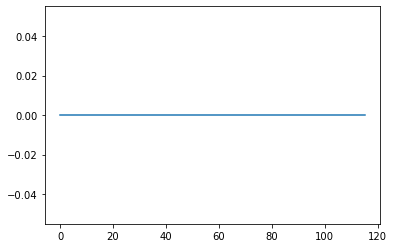

>Variable : /Platform/headingsize = (116,)
	statistics min:0.0 max:0.0


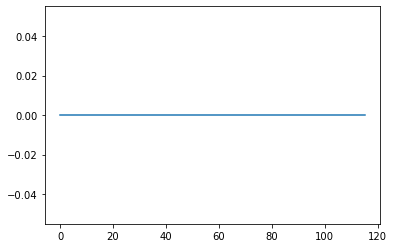

>Variable : /Platform/latitudesize = (116,)
	statistics min:0.0 max:0.0


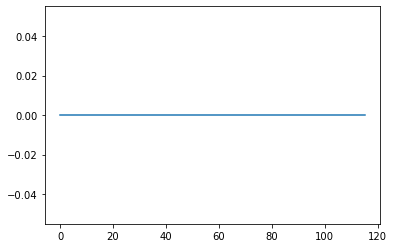

>Variable : /Platform/longitudesize = (116,)
	statistics min:0.0 max:0.0


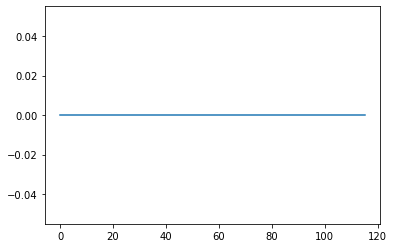

>Variable : /Platform/pitchsize = (116,)
	statistics min:0.0 max:0.0


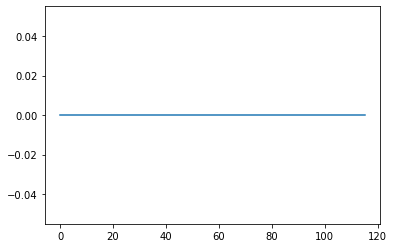

>Non displayed variable : /Platform/position_offset_x size =()
	Values =0.0
>Non displayed variable : /Platform/position_offset_y size =()
	Values =0.0
>Non displayed variable : /Platform/position_offset_z size =()
	Values =0.0
>Variable : /Platform/rollsize = (116,)
	statistics min:0.0 max:0.0


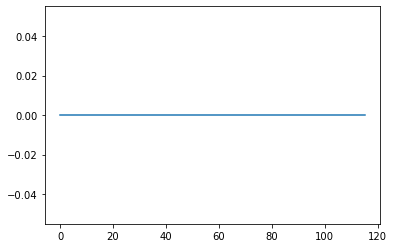

>Variable : /Platform/speed_groundsize = (116,)
	statistics min:0.0 max:0.0


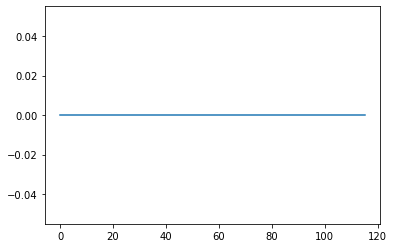

>Variable : /Platform/speed_relativesize = (116,)
	statistics min:0.0 max:0.0


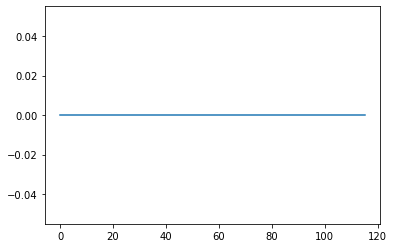

>Variable : /Platform/time1size = (116,)
	statistics min:13212689805169320400 max:13212689920168254900


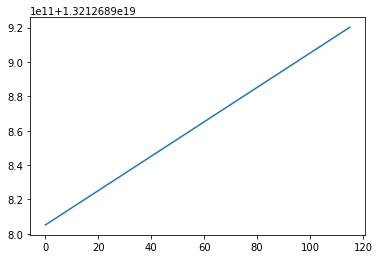

>Non displayed variable : /Platform/transducer_offset_x size =()
	Values =0.0
>Non displayed variable : /Platform/transducer_offset_y size =()
	Values =0.0
>Non displayed variable : /Platform/transducer_offset_z size =()
	Values =0.0
>Variable : /Platform/vertical_offsetsize = (116,)
	statistics min:0.0 max:0.0


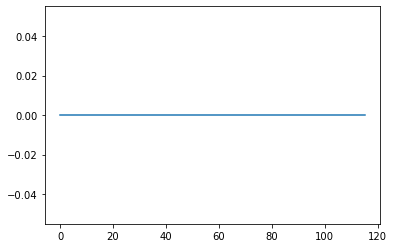

>Non displayed variable : /Platform/water_level size =()
	Values =0.0
>Ignored variable :NMEA_datagram
>Ignored variable :time
>1D variable with a null size/Environment/absorption_indicative size =(0,)
>1D variable with a null size/Environment/frequency size =(0,)
>Non displayed variable : /Environment/sound_speed_indicative size =()
	Values =0.0
>Ignored variable :annotation_category
>Ignored variable :annotation_text
>Ignored variable :time
>Variable : /Sonar/ping_timesize = (116,)
	statistics min:13212689805169320400 max:13212689920168254900


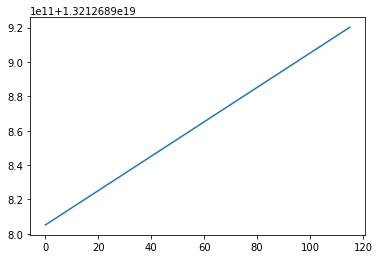

>Variable : /Sonar/Beam_group1/backscatter_isize =(10678, 4)
	statistics min:-65152.0 max:65472.0


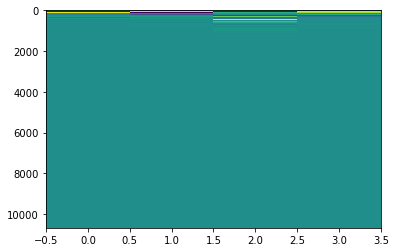

>Variable : /Sonar/Beam_group1/backscatter_rsize =(10678, 4)
	statistics min:-65440.0 max:65344.0


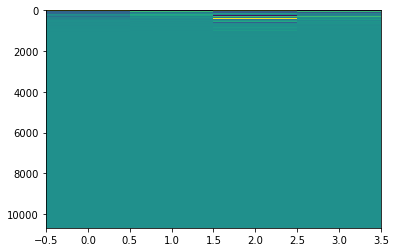

>Ignored variable :beam
>Variable : /Sonar/Beam_group1/beam_direction_xsize =(4, 116)
	statistics min:-0.35355338 max:0.35355338


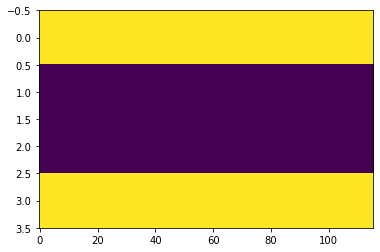

>Variable : /Sonar/Beam_group1/beam_direction_ysize =(4, 116)
	statistics min:-0.35355338 max:0.35355338


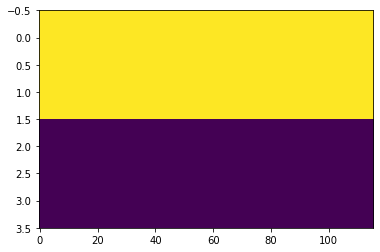

>Variable : /Sonar/Beam_group1/beam_direction_zsize =(4, 116)
	statistics min:0.8660254 max:0.8660254


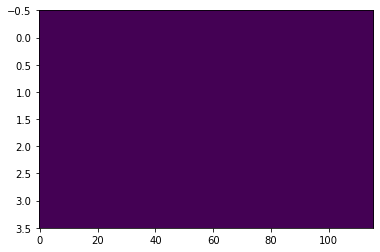

>Variable : /Sonar/Beam_group1/beam_stabilisationsize = (116,)
	statistics min:0 max:0


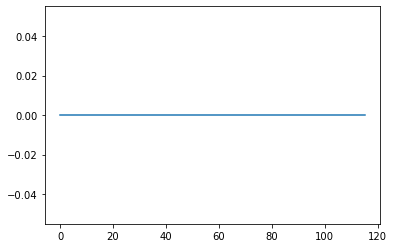

>Variable : /Sonar/Beam_group1/beam_typesize = (116,)
	statistics min:0 max:0


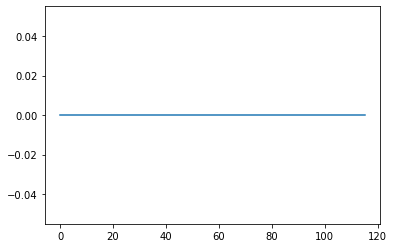

>Variable : /Sonar/Beam_group1/beamwidth_receive_majorsize =(4, 116)
	statistics min:2.4 max:2.4


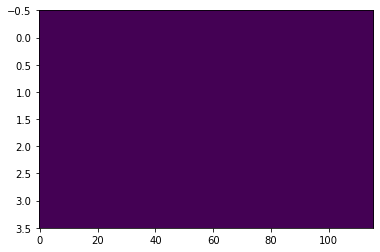

>Variable : /Sonar/Beam_group1/beamwidth_receive_minorsize =(4, 116)
	statistics min:2.4 max:2.4


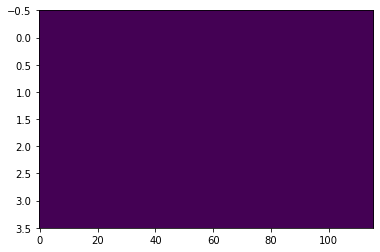

>Variable : /Sonar/Beam_group1/beamwidth_transmit_majorsize =(4, 116)
	statistics min:2.4 max:2.4


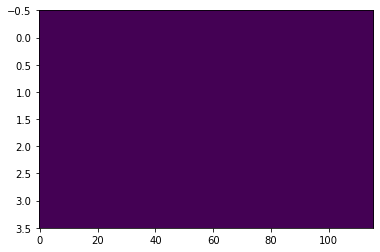

>Variable : /Sonar/Beam_group1/beamwidth_transmit_minorsize =(4, 116)
	statistics min:2.4 max:2.4


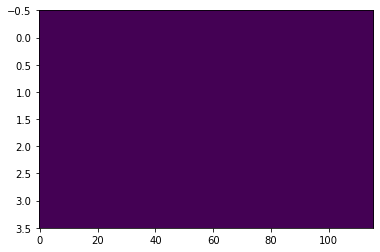

>Variable : /Sonar/Beam_group1/blanking_intervalsize = (116,)
	statistics min:0.0 max:0.0


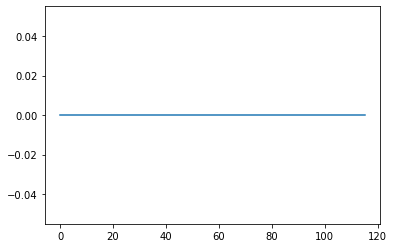

>Variable : /Sonar/Beam_group1/equivalent_beam_anglesize =(4, 116)
	statistics min:0.0 max:0.0


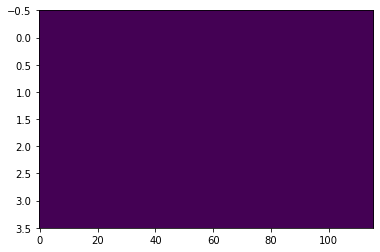

>Variable : /Sonar/Beam_group1/gain_correctionsize =(4, 116)
	statistics min:0.0 max:0.0


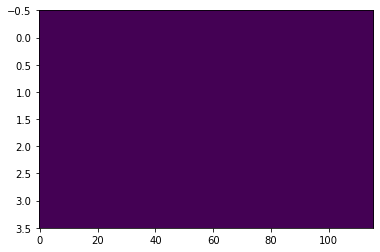

>Variable : /Sonar/Beam_group1/non_quantitative_processingsize = (116,)
	statistics min:0 max:0


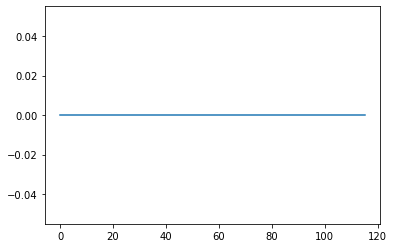

>Variable : /Sonar/Beam_group1/platform_headingsize = (116,)
	statistics min:0.0 max:0.0


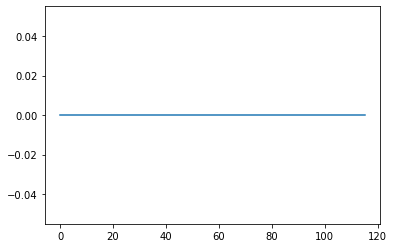

>Variable : /Sonar/Beam_group1/platform_latitudesize = (116,)
	statistics min:0.0 max:0.0


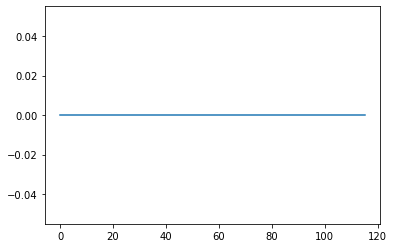

>Variable : /Sonar/Beam_group1/platform_longitudesize = (116,)
	statistics min:0.0 max:0.0


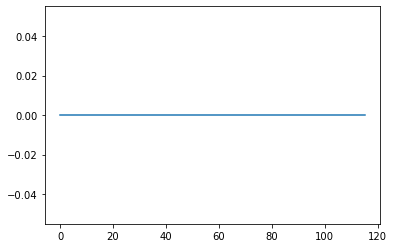

>Variable : /Sonar/Beam_group1/platform_pitchsize = (116,)
	statistics min:0.0 max:0.0


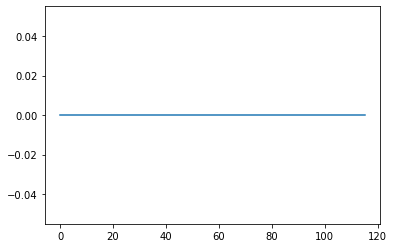

>Variable : /Sonar/Beam_group1/platform_rollsize = (116,)
	statistics min:0.0 max:0.0


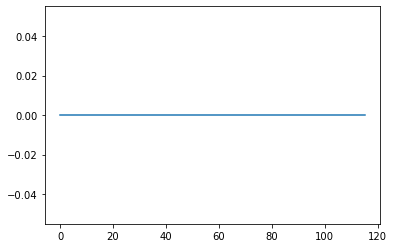

>Variable : /Sonar/Beam_group1/platform_verticalsize = (116,)
	statistics min:0.0 max:0.0


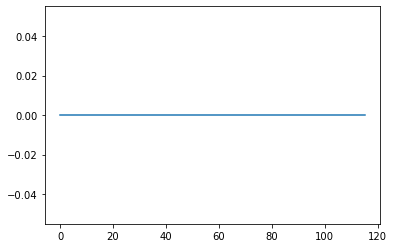

>Variable : /Sonar/Beam_group1/receiver_sensitivitysize =(4, 116)
	statistics min:0.0 max:0.0


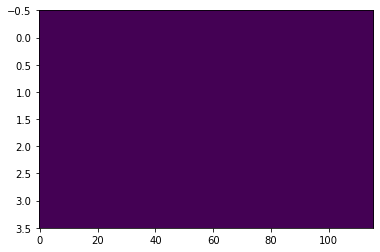

>Variable : /Sonar/Beam_group1/sample_intervalsize = (116,)
	statistics min:0.0 max:0.0


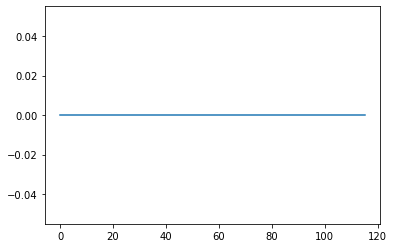

>Variable : /Sonar/Beam_group1/sample_time_offsetsize = (116,)
	statistics min:0.0 max:0.0


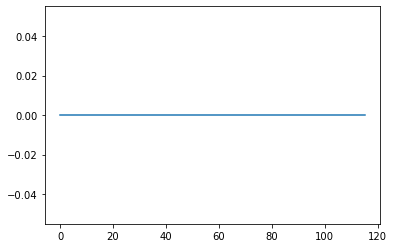

>Variable : /Sonar/Beam_group1/sound_speed_at_transducersize = (116,)
	statistics min:0.0 max:0.0


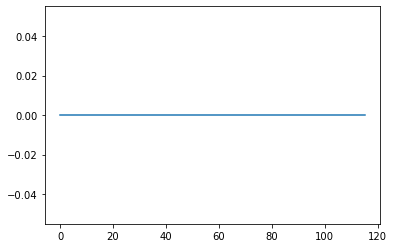

>Variable : /Sonar/Beam_group1/time_varied_gainsize = (116,)
	statistics min:0.0 max:0.0


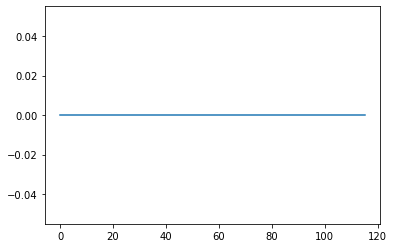

>Variable : /Sonar/Beam_group1/transducer_gainsize =(4, 116)
	statistics min:0.0 max:0.0


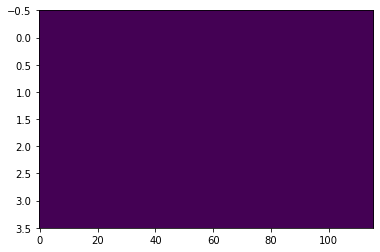

>Variable : /Sonar/Beam_group1/transmit_bandwidthsize = (116,)
	statistics min:0.0 max:0.0


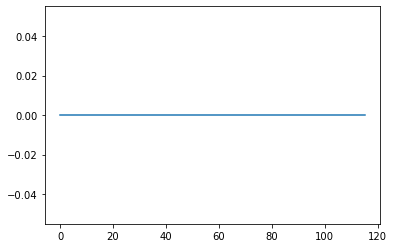

>Variable : /Sonar/Beam_group1/transmit_duration_equivalentsize = (116,)
	statistics min:0.0030792016 max:0.0030792016


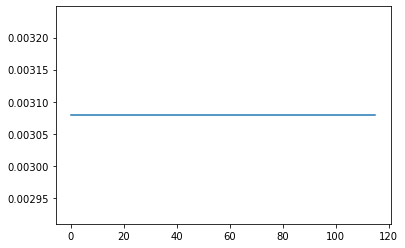

>Variable : /Sonar/Beam_group1/transmit_duration_nominalsize = (116,)
	statistics min:0.0030792016 max:0.0030792016


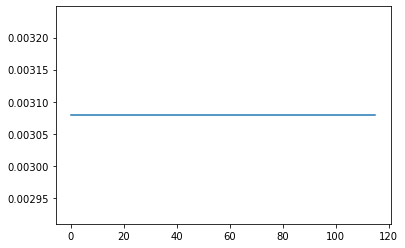

>Variable : /Sonar/Beam_group1/transmit_frequency_startsize = (116,)
	statistics min:150000.0 max:150000.0


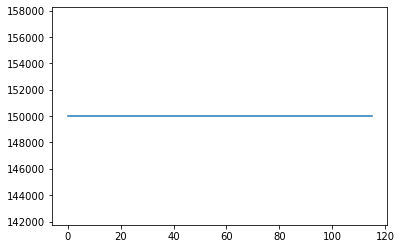

>Variable : /Sonar/Beam_group1/transmit_frequency_stopsize = (116,)
	statistics min:150000.0 max:150000.0


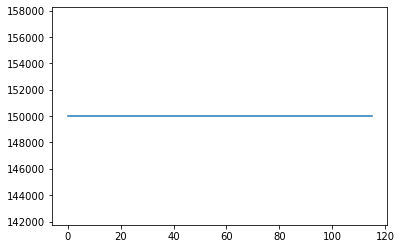

>Variable : /Sonar/Beam_group1/transmit_modesize = (116,)
	statistics min:1 max:1


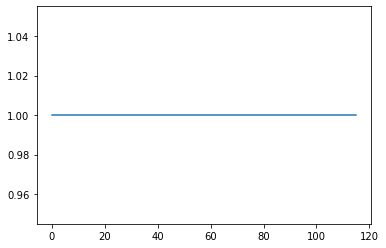

>Variable : /Sonar/Beam_group1/transmit_powersize = (116,)
	statistics min:200.0 max:200.0


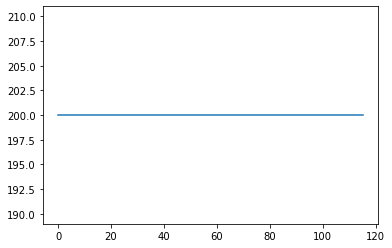

>Variable : /Sonar/Beam_group1/transmit_source_levelsize = (116,)
	statistics min:0.0 max:0.0


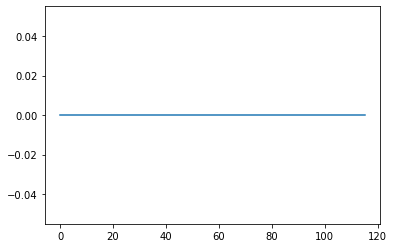

>Variable : /Sonar/Beam_group1/transmit_typesize = (116,)
	statistics min:0 max:0


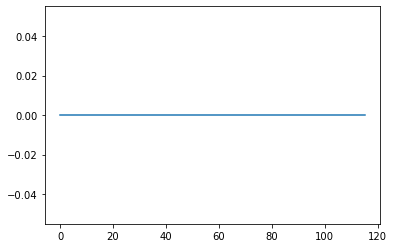

>Variable : /Sonar/Beam_group1/water_temperature_at_transducersize = (116,)
	statistics min:0.0 max:0.0


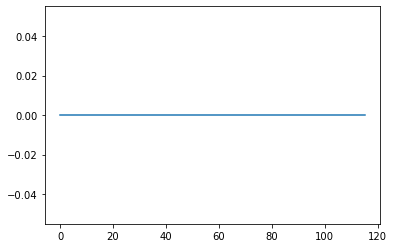

>Variable : /Sonar/Beam_group1/ADCP/back_scatter_at_bottom_isize =(4, 116)
	statistics min:-1.8378906 max:1.375


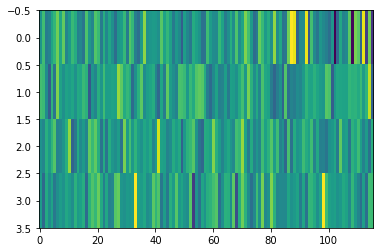

>Variable : /Sonar/Beam_group1/ADCP/back_scatter_at_bottom_rsize =(4, 116)
	statistics min:-1.2441406 max:1.8525391


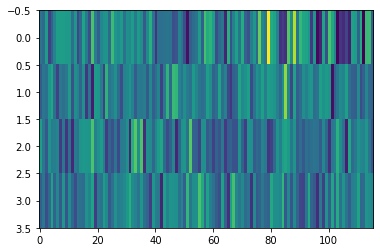

>Variable : /Sonar/Beam_group1/ADCP/bin_lengthsize = (116,)
	statistics min:0.0 max:0.0


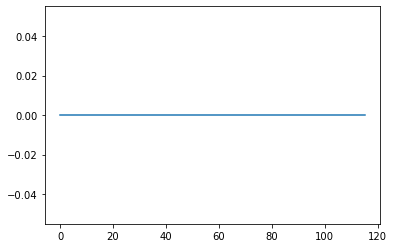

>Variable : /Sonar/Beam_group1/ADCP/bottom_track_velocity_vessel_xsize = (116,)
	statistics min:-7.2141914 max:5.212941


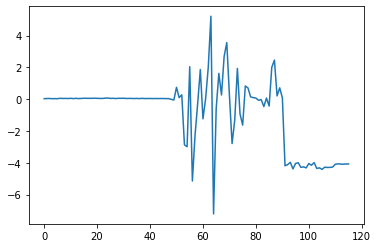

>Variable : /Sonar/Beam_group1/ADCP/bottom_track_velocity_vessel_ysize = (116,)
	statistics min:-6.339523 max:5.082599


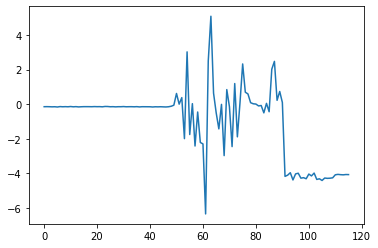

>Variable : /Sonar/Beam_group1/ADCP/bottom_track_velocity_vessel_zsize = (116,)
	statistics min:-1.1886572 max:2.0154958


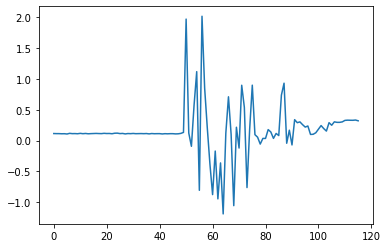

>Variable : /Sonar/Beam_group1/ADCP/correlationsize =(1050, 4)
	statistics min:0.0 max:0.0


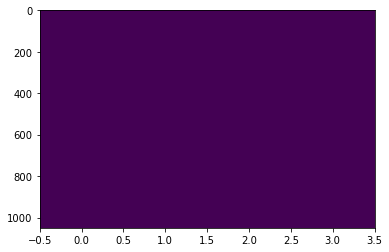

>Variable : /Sonar/Beam_group1/ADCP/correlation_at_bottomsize =(4, 116)
	statistics min:0 max:0


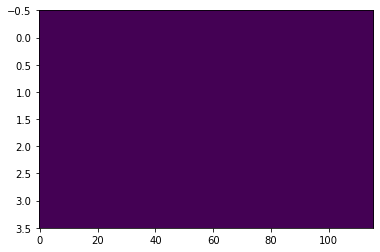

>Variable : /Sonar/Beam_group1/ADCP/current_velocity_geographical_downsize = (10491,)
	statistics min:-1.1353494 max:0.4550356


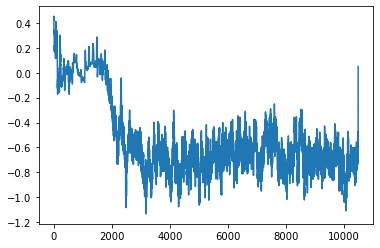

>Variable : /Sonar/Beam_group1/ADCP/current_velocity_geographical_eastsize = (10491,)
	statistics min:-1.1033789 max:1.0113031


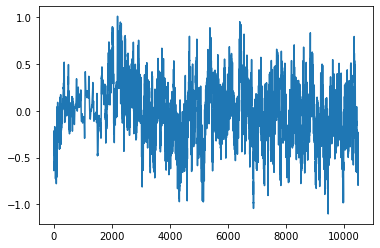

>Variable : /Sonar/Beam_group1/ADCP/current_velocity_geographical_northsize = (10491,)
	statistics min:-1.0094333 max:1.059496


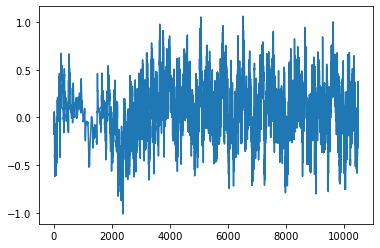

>Variable : /Sonar/Beam_group1/ADCP/current_velocity_vessel_xsize = (10491,)
	statistics min:-13.239199 max:13.197698


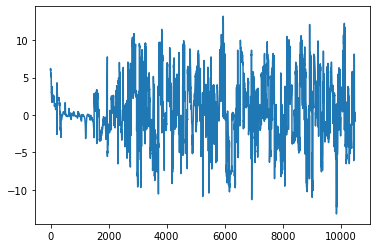

>Variable : /Sonar/Beam_group1/ADCP/current_velocity_vessel_ysize = (10491,)
	statistics min:-13.645297 max:12.737577


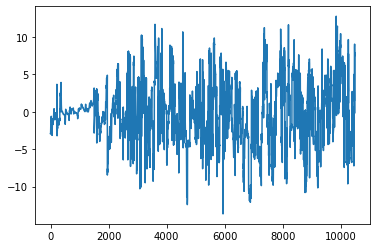

>Variable : /Sonar/Beam_group1/ADCP/current_velocity_vessel_zsize = (10491,)
	statistics min:-4.888432 max:4.9211373


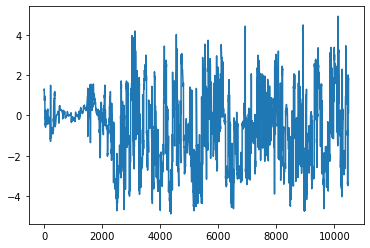

>Variable : /Sonar/Beam_group1/ADCP/depth_first_sample_centersize = (116,)
	statistics min:2.713621 max:2.713621


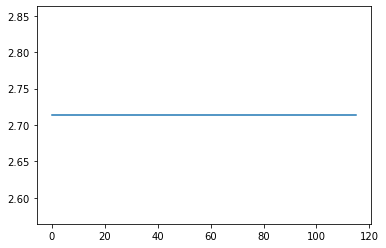

>Variable : /Sonar/Beam_group1/ADCP/qualitysize = (4,)
	statistics min:0 max:0


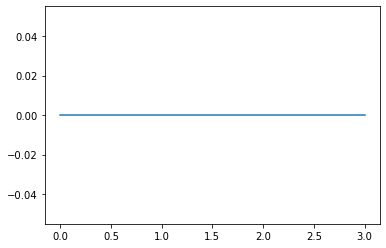

>Variable : /Sonar/Beam_group1/ADCP/slant_range_to_bottomsize =(4, 116)
	statistics min:0.0 max:0.0


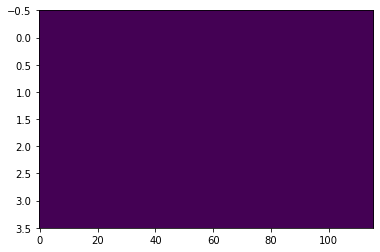

>Variable : /Sonar/Beam_group1/ADCP/transmit_duration_nominal_sub_pulsesize = (116,)
	statistics min:0.0 max:0.0


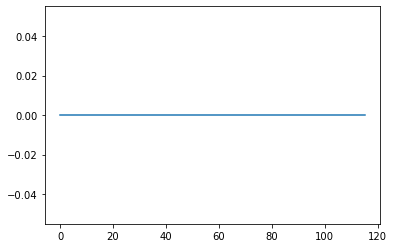

>Variable : /Sonar/Beam_group1/ADCP/transmit_lag_interval_sub_pulsesize = (116,)
	statistics min:0.0 max:0.0


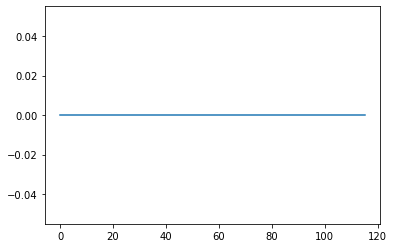

>Variable : /Sonar/Beam_group1/ADCP/velocitysize =(1050, 4)
	statistics min:-4.9425077 max:4.970081


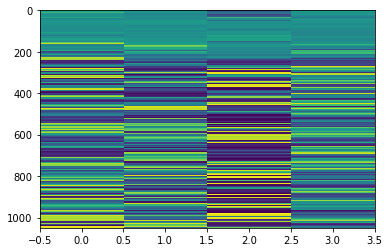

>Variable : /Sonar/Beam_group1/ADCP/velocity_depth_stabilizationsize = (116,)
	statistics min:0 max:0


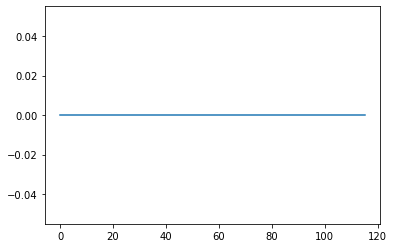

>Variable : /Sonar/Beam_group1/ADCP/velocity_motion_stabilizationsize = (116,)
	statistics min:0 max:0


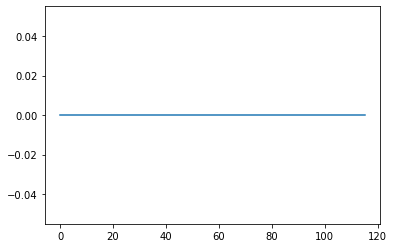

>Variable : /Sonar/Beam_group1/ADCP/vertical_sample_intervalsize = (116,)
	statistics min:0.024366928 max:0.024366928


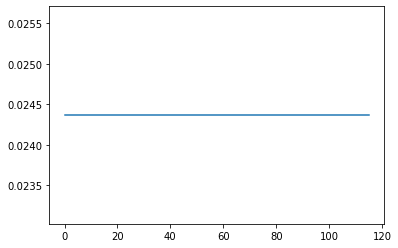

>Variable : /Sonar/Beam_group1/ADCP/Mean-current/averagingsize = (116,)
	statistics min:1 max:1


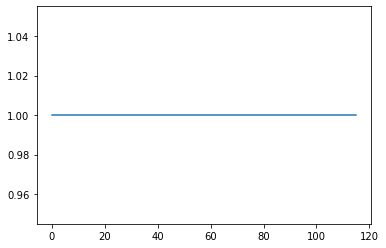

>Variable : /Sonar/Beam_group1/ADCP/Mean-current/bottom_track_velocity_vessel_xsize = (116,)
	statistics min:-0.6757161 max:-0.16212225


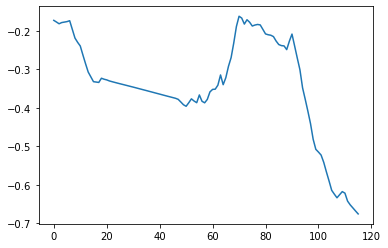

>Variable : /Sonar/Beam_group1/ADCP/Mean-current/bottom_track_velocity_vessel_ysize = (116,)
	statistics min:-0.8372182 max:-0.26028606


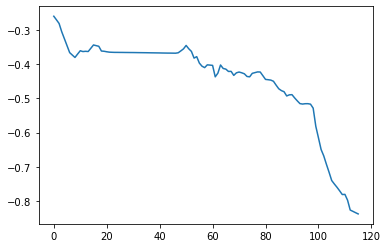

>Variable : /Sonar/Beam_group1/ADCP/Mean-current/bottom_track_velocity_vessel_zsize = (116,)
	statistics min:0.040479783 max:0.15800299


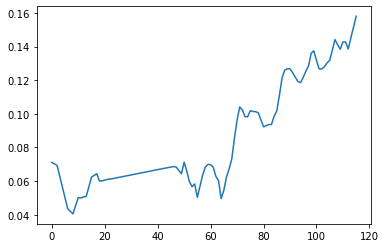

>Variable : /Sonar/Beam_group1/ADCP/Mean-current/current_velocity_geographical_downsize = (10491,)
	statistics min:-1.1353494 max:0.4550356


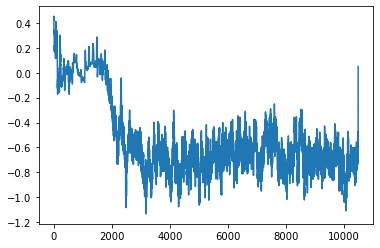

>Variable : /Sonar/Beam_group1/ADCP/Mean-current/current_velocity_geographical_eastsize = (10491,)
	statistics min:-1.1033789 max:1.0113031


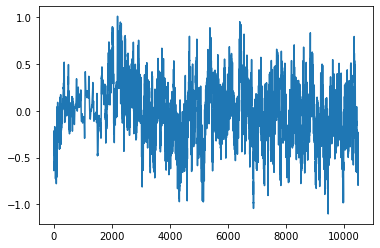

>Variable : /Sonar/Beam_group1/ADCP/Mean-current/current_velocity_geographical_northsize = (10491,)
	statistics min:-1.0094333 max:1.059496


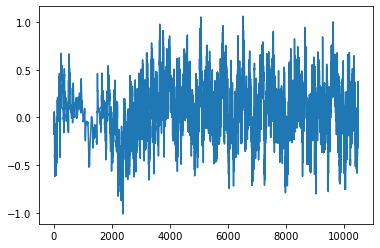

>Variable : /Sonar/Beam_group1/ADCP/Mean-current/current_velocity_vessel_xsize = (10491,)
	statistics min:-1.0094333 max:1.059496


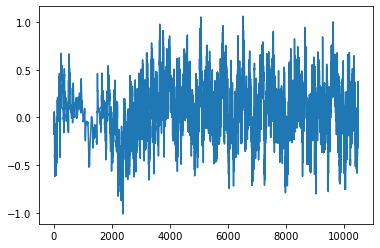

>Variable : /Sonar/Beam_group1/ADCP/Mean-current/current_velocity_vessel_ysize = (10491,)
	statistics min:-1.1033789 max:1.0113031


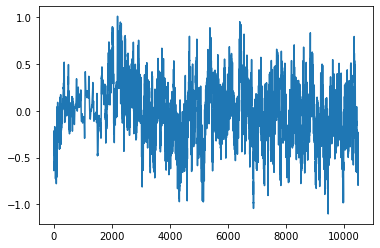

>Variable : /Sonar/Beam_group1/ADCP/Mean-current/current_velocity_vessel_zsize = (10491,)
	statistics min:-1.1353494 max:0.4550356


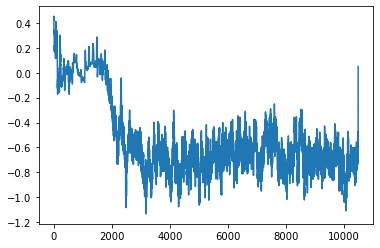

>Variable : /Sonar/Beam_group1/ADCP/Mean-current/mean_bin_lengthsize = (116,)
	statistics min:0.0 max:0.0


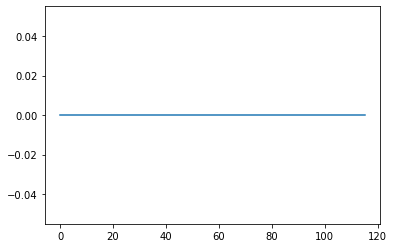

>Variable : /Sonar/Beam_group1/ADCP/Mean-current/mean_platform_headingsize = (116,)
	statistics min:0.0 max:0.0


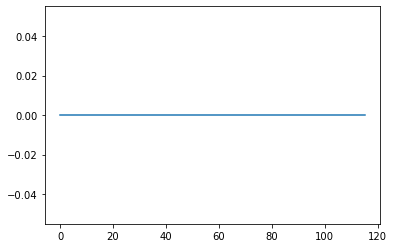

>Variable : /Sonar/Beam_group1/ADCP/Mean-current/mean_platform_latitudesize = (116,)
	statistics min:0.0 max:0.0


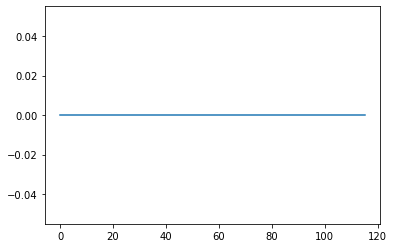

>Variable : /Sonar/Beam_group1/ADCP/Mean-current/mean_platform_longitudesize = (116,)
	statistics min:0.0 max:0.0


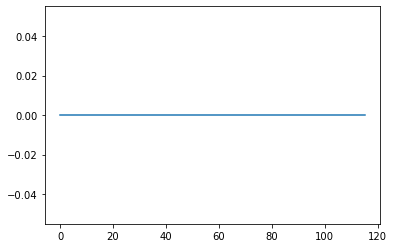

>Variable : /Sonar/Beam_group1/ADCP/Mean-current/mean_platform_pitchsize = (116,)
	statistics min:0.0 max:0.0


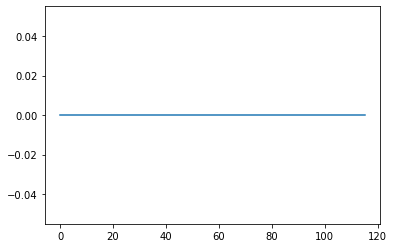

>Variable : /Sonar/Beam_group1/ADCP/Mean-current/mean_platform_rollsize = (116,)
	statistics min:0.0 max:0.0


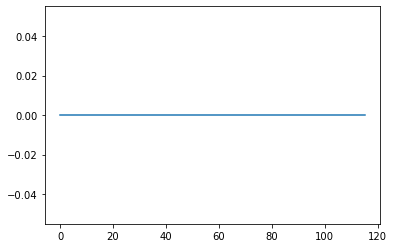

>Variable : /Sonar/Beam_group1/ADCP/Mean-current/mean_platform_verticalsize = (116,)
	statistics min:0.0 max:0.0


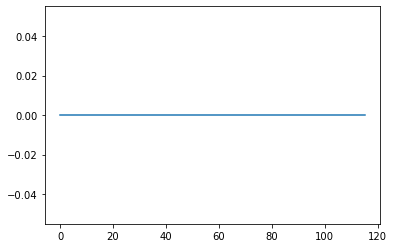

>Variable : /Sonar/Beam_group1/ADCP/Mean-current/mean_timesize = (116,)
	statistics min:13212689805169320400 max:13212689920168254900


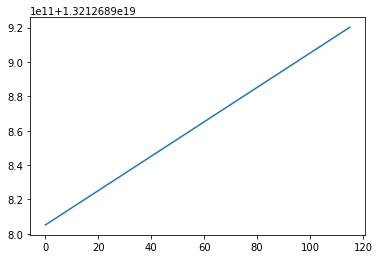

>Variable : /Sonar/Beam_group1/ADCP/Mean-current/ping_averagedsize = (1,)
	statistics min:20 max:20


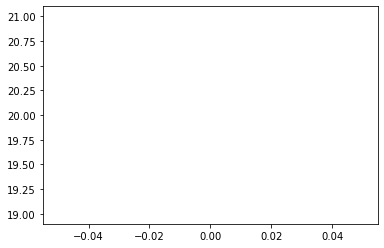

In [7]:
reader= ADCPReader(file_path)
recurse_file_groups(reader,reader.dataset,ping)